# Import Required Modules

In [1]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
output_notebook()

Loading BokehJS ...

## Instantiate a grid from a DEM raster
Some sample data is already included, but for extra data, see the [USGS hydrosheds project](https://hydrosheds.cr.usgs.gov/datadownload.php).

In [151]:
# grid = Grid.from_raster('data/n45w125_con_grid/n45w125_con/n45w125_con', data_name='dem')
grid = Grid.from_ascii('data/n45w125_con_grid/n49w1235_con_grid/n49w1235_con_grid.asc', 
                       data_name='dem')

In [152]:
map_extents = grid.extent
print(grid.__dict__.keys())

dict_keys(['_affine', 'shape', 'nodata', '_crs', 'mask', 'grids', 'dem'])


In [175]:
grid.nodata = 0

In [178]:
# set bokeh plot tools
from bokeh.models import LinearColorMapper, LogTicker, ColorBar, BasicTickFormatter
tools = "pan,wheel_zoom,box_zoom,reset,tap"
TOOLTIPS = [
    ("(x,y)", "($x, $y)"),
]

# create a figure, setting the x and y ranges to the appropriate data bounds
p1 = figure(title="Test", plot_width=600, plot_height=int(400),
            x_range = map_extents[:2], y_range = map_extents[2:], 
            tools=tools, tooltips=TOOLTIPS)

min_x, max_x, min_y, max_y = map_extents

color_mapper = LinearColorMapper(palette="Magma256", low=-200, high=2400)

adjusted_img = np.flipud(grid.dem)  # np.flipud flips the image data on a vertical axis

p1.image(image=adjusted_img,   
         x=[min_x],               # lower left x coord
         y=[min_y],               # lower left y coord
         dw=[max_x-min_x],        # *data space* width of image
         dh=[max_y-min_y],        # *data space* height of image
         color_mapper=color_mapper
)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=Ticker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p1.add_layout(color_bar, 'right')


show(p1)

RuntimeError: Columns need to be 1D (image is not)

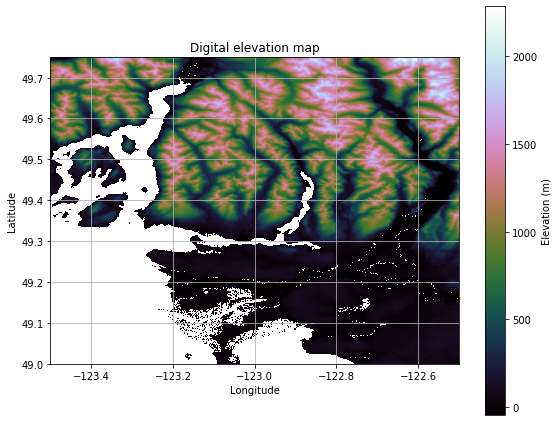

In [142]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('img/conditioned_dem.png', bbox_inches='tight')

## Resolve flats in DEM

In [138]:
grid.resolve_flats('dem', out_name='inflated_dem')

## Specify flow direction values

In [ ]:
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [ ]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()
plt.savefig('img/flow_direction.png', bbox_inches='tight')

In [ ]:
grid.read_raster('data/n30w100_dir_grid/n30w100_dir/n30w100_dir', data_name='dir')

In [ ]:
grid.dir

In [ ]:
grid.dir.size

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()

## Delineate the Catchment

In [ ]:
# Specify pour point
x, y = -97.294167, 32.73750
# x, y = -97.3542, 32.6402

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [ ]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [ ]:
# Get a view of the catchment
catch = grid.view('catch', nodata=np.nan)

In [ ]:
print(catch.shape)

In [ ]:
print(grid.extent)

In [ ]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
plt.savefig('img/catchment.png', bbox_inches='tight')

## Get flow accumulation

In [ ]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('img/flow_accumulation.png', bbox_inches='tight')


## Calculate distances to upstream cells

In [ ]:
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance')
plt.savefig('img/flow_distance.png', bbox_inches='tight')